In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imageio import imread

import sys

sys.path.insert(0, "../src")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction

utils.plot_settings()  # LaTeX fonts in Plots!

FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents
SEEDVAL = 2018

In [2]:
spacing=100 # Try 100, or try 40 (waring, 40 can be slow, so probably turn off boot and subset).
max_degree=20
n_lambdas=30
k_folds=5
n_bootstraps=100
do_boot= True # To save computation time, set to False. Will then not perform bias-variance-analysis.
do_subset= True # To save computation time, set to False. Will then not perform bias-variance analysis for subset
                    # of hyper-parameters.

np.random.seed(SEEDVAL)
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data

terrain_data = imread("../datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:spacing, :1801:spacing]  # Make square and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables

lambdas = np.logspace(-6, 0, n_lambdas)
subset_lambdas = np.logspace(-6, 0, 7)

x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

# Centering
z_intercept = np.mean(z)
z = z - z_intercept

z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

##### Setup of problem is completede above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.

    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Probably should not have this.

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 # Probably actually not
    #    X_test_scaled[:,0] = 1 # Have a bad feeling about how this might affect ridge/lasso.

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree.

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    if do_boot:
        # All regression bootstraps at once

        lamb_ridge = best_ridge_lambda[degree_index]
        lamb_lasso = best_lasso_lambda[degree_index]

        (
            ridge_mse,
            ridge_bias,
            ridge_variance,
            lasso_mse,
            lasso_bias,
            lasso_variance,
            ols_mse,
            ols_bias,
            ols_variance,
        ) = bootstrap.bootstrap_all(
            X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
        )

        (
            ridge_best_lambda_boot_mse[degree_index],
            ridge_best_lambda_boot_bias[degree_index],
            ridge_best_lambda_boot_variance[degree_index],
        ) = (ridge_mse, ridge_bias, ridge_variance)

        (
            lasso_best_lambda_boot_mse[degree_index],
            lasso_best_lambda_boot_bias[degree_index],
            lasso_best_lambda_boot_variance[degree_index],
        ) = (lasso_mse, lasso_bias, lasso_variance)

        ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
            ols_mse,
            ols_bias,
            ols_variance,
        )

    if do_subset:
        # Bootstrapping for a selection of lambdas for ridge and lasso
        subset_lambda_index = 0
        for lamb in subset_lambdas:

            (
                ridge_mse,
                ridge_bias,
                ridge_variance,
                lasso_mse,
                lasso_bias,
                lasso_variance,
            ) = bootstrap.bootstrap_ridge_lasso(
                X_train_scaled,
                X_test_scaled,
                z_train,
                z_test,
                n_bootstraps,
                lamb_lasso,
                lamb_ridge,
            )

            (
                ridge_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (ridge_mse, ridge_bias, ridge_variance)

            (
                lasso_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (lasso_mse, lasso_bias, lasso_variance)

            subset_lambda_index += 1


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5476123.161124904, tolerance: 2135.5099460102365
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5101372.297941006, tolerance: 1946.9941687249177
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4901690.690877314, tolerance: 1959.2764069520647
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4694284.318879403, tolerance: 1946.9941687249177
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4691913.937918401, tolerance: 1959.2764069520647
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5252945.196794302, tolerance: 2155.6761612456935
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27355.92239785008, tolerance: 1875.3370878472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11958.06494606845, tolerance: 2091.001449652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99421.50101112854, tolerance: 1813.4754447916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26587.482791596092, tolerance: 1782.1512802083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65429.97238112334, tolerance: 1954.2022746527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58593.6704228241, tolerance: 2014.4199531250001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19672.975662274286, tolerance: 2102.2640913194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5181.231969391927, tolerance: 1906.7552378472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34242.65918564983, tolerance: 1988.2454392361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39301.19671633467, tolerance: 1734.8443767361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33818.8143038908, tolerance: 1807.9797940972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101121.24188285694, tolerance: 1851.9327677083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30945.643667148426, tolerance: 1986.3637336805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48078.42465054896, tolerance: 2125.954928125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35884.99420035072, tolerance: 2124.7509274305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26151.811990013346, tolerance: 1802.0461975694448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12874.037915593013, tolerance: 1892.3320496527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5811.987889070064, tolerance: 2226.827655208334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89211.59864155948, tolerance: 1875.2756892361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334029.2785826763, tolerance: 2212.012515625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140243.27315959707, tolerance: 2429.303328125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergenc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43228.94670789316, tolerance: 1903.5581434027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19482.664521113038, tolerance: 1987.5158982638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47069.8435693793, tolerance: 2103.2123593750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52497.56752812397, tolerance: 1648.5510975694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115884.9334123265, tolerance: 2144.379580902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42657.637198493816, tolerance: 1759.3983927083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64301.36540301051, tolerance: 2403.004573263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41443.9861618625, tolerance: 2039.048828125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56552.83763201255, tolerance: 1817.248570486111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergenc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4951986.840196982, tolerance: 1985.2486316058041
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4993106.239523412, tolerance: 2160.5273691446505
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4953787.561027561, tolerance: 1952.3830410240867
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4938392.502254775, tolerance: 1952.3830410240867
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5042634.284694047, tolerance: 2158.0686631847516
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4976093.190390592, tolerance: 2049.57490113489
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4274750.604570618, tolerance: 2049.57490113489
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4235439.752438562, tolerance: 1985.2486316058041
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4157756.3030733103, tolerance: 2160.5273691446505
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4765705.238971555, tolerance: 2178.8263767361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4043822.7329843296, tolerance: 2017.8864545138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4537453.089101712, tolerance: 2081.1043940972227
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3789843.277750889, tolerance: 1751.5332538194448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4287023.835510239, tolerance: 1860.8001302083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3998265.7134176805, tolerance: 1975.6114177083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4217877.693329656, tolerance: 1996.6915156250002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4692005.302583697, tolerance: 2082.238974652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4268934.748470808, tolerance: 2109.7334253472227
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4272490.406187608, tolerance: 2107.7224246527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3810210.1906784424, tolerance: 1752.112728125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3986142.132313811, tolerance: 1883.2174663194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4363010.9369828645, tolerance: 1996.3405177083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4159875.4859186136, tolerance: 2178.2168225694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3904971.456810061, tolerance: 1848.658479513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4477749.337227674, tolerance: 1987.8515927083338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3534648.639861099, tolerance: 1785.9874565972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3753479.6859686975, tolerance: 1683.753654513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3878945.5899821986, tolerance: 1750.937753125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4742231.982998902, tolerance: 2134.111467013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3912791.268950583, tolerance: 1933.6950427083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4552886.394591878, tolerance: 1925.2412413194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3935810.1782432846, tolerance: 1841.3715274305553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4429275.861718895, tolerance: 1846.4243003472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3397627.3465299984, tolerance: 1873.5514899305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4480385.371926706, tolerance: 2257.485259375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3568245.227559586, tolerance: 1692.8595288194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4317168.058318267, tolerance: 1917.7531927083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3646080.1869608974, tolerance: 1955.210260763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3627579.6199233364, tolerance: 1785.8799947916668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4130842.5790264616, tolerance: 1955.7249802083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4522351.953768944, tolerance: 2129.296195486111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4272470.425924376, tolerance: 2418.9939142361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3733476.1468623145, tolerance: 1675.5064086805558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4332715.312113082, tolerance: 2051.7250538194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3961896.5726169753, tolerance: 2097.265778125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4259456.505017149, tolerance: 1985.8197406250001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4398951.851553902, tolerance: 2015.5576086805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4857186.019173474, tolerance: 2058.9857954861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5045421.776881516, tolerance: 2151.744306398048
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4568614.508180152, tolerance: 2117.498259860652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4828842.810865418, tolerance: 2056.5796895005415
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4825183.51285803, tolerance: 2056.5796895005415
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4249238.63055972, tolerance: 1952.1017101418809
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4437477.220878739, tolerance: 2027.878640193062
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4341691.523090508, tolerance: 2117.498259860652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4561596.727902185, tolerance: 2056.5796895005415
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4055649.9779124036, tolerance: 1952.1017101418809
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29876.419937392697, tolerance: 1952.1017101418809
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4351233.006235896, tolerance: 1975.3003017361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3795297.7565624393, tolerance: 1856.7458711805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4290231.059456279, tolerance: 2098.8298329861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3587680.7611142895, tolerance: 1741.7347017361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3927338.6216472927, tolerance: 1933.6928302083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3091110.5931992927, tolerance: 1906.9611635416668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4066523.182566842, tolerance: 1898.5763545138889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3791571.2294835965, tolerance: 2051.271196875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3838174.507973535, tolerance: 2041.7293753472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3741744.237511848, tolerance: 1956.2582371527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4035751.5556974197, tolerance: 2279.424257986111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4823708.192895615, tolerance: 2346.686162847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3920205.926323329, tolerance: 2063.9300961805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3268632.472980586, tolerance: 1640.2247954861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3539780.7818511454, tolerance: 1733.9276788194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3632094.2042335, tolerance: 1971.0526031250001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4435087.50922409, tolerance: 1748.0875934027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4051220.122857061, tolerance: 2080.743955902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4258884.066823651, tolerance: 2069.4887378472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4462306.478208123, tolerance: 2265.2770503472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3348393.4366597338, tolerance: 1828.9291961805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3082939.639278987, tolerance: 1850.5574503472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3876680.72088078, tolerance: 2109.5176586805555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4238913.1229640525, tolerance: 1991.4821093750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3924729.577025437, tolerance: 2011.6917420138889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3940113.2204890475, tolerance: 2131.181546875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4075989.5193881975, tolerance: 1751.801055902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3657520.5604769913, tolerance: 1931.0744621527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4107247.8488036017, tolerance: 2359.3710864583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3706526.9980628677, tolerance: 1844.2458788194442
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4007793.9810711057, tolerance: 2012.0558822916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4260051.956667457, tolerance: 2019.0643413194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3259720.9373265295, tolerance: 1946.2468927083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3927325.0935164695, tolerance: 2050.7595336805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3948263.8908472653, tolerance: 1885.6544920138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3501003.2803335516, tolerance: 1801.8111600694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3603752.7957759392, tolerance: 1932.263409375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3724502.042067168, tolerance: 1965.8019371527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3825211.215943173, tolerance: 2076.8417510416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3917470.1041696006, tolerance: 1999.947492013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4321063.753996968, tolerance: 2174.5708822916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3522176.8197178403, tolerance: 2166.192253125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3160533.978691806, tolerance: 1929.933809375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4027379.744150108, tolerance: 1851.9809934027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergenc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3335267.1731167724, tolerance: 1716.7078989583338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4552191.476051279, tolerance: 2174.6215788194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3263642.2872724477, tolerance: 2172.955335763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3637277.0293103517, tolerance: 1909.7117809027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3864375.2254697066, tolerance: 2306.8069447916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3980817.5897984514, tolerance: 2104.930524652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4681624.925727604, tolerance: 2196.7116611114097
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4556571.626837154, tolerance: 2161.189483960375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4177507.188333256, tolerance: 1965.6573160933392
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4554215.402417517, tolerance: 2161.189483960375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4175664.239860355, tolerance: 1965.6573160933392
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4414001.43316228, tolerance: 1951.0831964257486
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4124071.1632010085, tolerance: 1965.6573160933392
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4341820.486308625, tolerance: 1951.0831964257486
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3914943.7716826955, tolerance: 2031.1609485033111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2850192.8072517766, tolerance: 1965.6573160933392
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2435707.808497636, tolerance: 1951.0831964257486
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2953215.936796829, tolerance: 2031.1609485033111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2461670.6185304914, tolerance: 2005.7039399305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2659537.638685148, tolerance: 2041.6972843750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295140.970618912, tolerance: 1845.0039934027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1485801.9927397151, tolerance: 2063.495836458333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1903130.9301159033, tolerance: 1663.8820704861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1999501.4142215163, tolerance: 2013.8147996527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1929623.801867925, tolerance: 1970.1327552083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2756997.0097438633, tolerance: 1783.376403819444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2192836.634735531, tolerance: 1925.9971086805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1751585.931995144, tolerance: 1837.1458350694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2471662.1318221153, tolerance: 1943.851136458333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1530417.0451472234, tolerance: 1920.457392013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2281842.594578119, tolerance: 1957.148923263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1910364.312006886, tolerance: 1980.103704513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1888184.613391304, tolerance: 1885.0096711805554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1881614.928631084, tolerance: 2079.3877322916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2263546.1529780636, tolerance: 2001.044134375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2090163.9324916527, tolerance: 2162.9268614583334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1910114.6694266335, tolerance: 2242.0189642361115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2411934.7303924127, tolerance: 2197.8395434027775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2552802.8744651396, tolerance: 2166.0696621527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3078973.0324132536, tolerance: 2359.7632309027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2287246.609423005, tolerance: 2444.8772003472222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2415829.160905443, tolerance: 1920.563333680556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2654729.6192661445, tolerance: 2220.4178934027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2079641.7765627606, tolerance: 1834.1240163194448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2193829.255289364, tolerance: 2020.202338541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1919426.798204918, tolerance: 1985.5555315972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2282508.030944999, tolerance: 1807.2237503472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2002577.2574191566, tolerance: 2134.187832291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2216317.4222930865, tolerance: 1803.1047822916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1300926.8024800578, tolerance: 2094.271919097222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2399534.3148488356, tolerance: 1985.419990625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1573161.2594860424, tolerance: 2151.185373263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2438633.1555946628, tolerance: 2150.773071875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1505975.0001490233, tolerance: 1774.9974017361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2935725.4991851533, tolerance: 2219.8929281250003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2453970.3442575065, tolerance: 1947.6053288194448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2726533.4659313057, tolerance: 2401.8405135416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1880924.5902307462, tolerance: 2040.4144559027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2144487.9900848456, tolerance: 1750.736698263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2407510.3367470126, tolerance: 1826.8235114583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2054370.8448832366, tolerance: 2172.322507291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2241112.456480083, tolerance: 2178.5278739583337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2741748.2394042006, tolerance: 2236.505685763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2382549.683400428, tolerance: 2023.487829513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2720467.467386212, tolerance: 2281.777859375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2674485.401640643, tolerance: 2145.931377430556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2392307.103377819, tolerance: 1968.3118163194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2363603.743336398, tolerance: 2050.2190177083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1752047.753179396, tolerance: 2276.358872569445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2411709.931144298, tolerance: 2015.749990625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2644938.524650978, tolerance: 2214.8893899305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2576756.8943777746, tolerance: 2084.7546267361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1997057.3571715308, tolerance: 1674.4421822916668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093811.3119962043, tolerance: 1945.644092013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2021480.315262016, tolerance: 2370.0992815972227
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2913639.801375802, tolerance: 2373.1281079861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2524937.6072386946, tolerance: 2000.2937899305562
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2409776.02677391, tolerance: 2210.6352079861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2275383.9562222986, tolerance: 1989.749071875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2174139.6224480486, tolerance: 2047.787496875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2274299.0243793707, tolerance: 1914.777132291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4500590.88802284, tolerance: 2223.3690346528956
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3538557.437154443, tolerance: 1893.5217969797652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4279699.276203828, tolerance: 2014.5039052900152
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4384662.302220353, tolerance: 2135.2062173440963
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4295930.695734209, tolerance: 2039.2016518274106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4498365.4059091555, tolerance: 2223.3690346528956
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4256569.863850285, tolerance: 2014.5039052900152
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4361850.38424117, tolerance: 2135.2062173440963
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4260389.442984439, tolerance: 2039.2016518274106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4054359.689771077, tolerance: 2223.3690346528956
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3243505.8063959507, tolerance: 1893.5217969797652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3868535.270408984, tolerance: 2014.5039052900152
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1322947.6634496748, tolerance: 2135.2062173440963
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 760595.7756494936, tolerance: 2039.2016518274106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 659660.3997711735, tolerance: 2223.3690346528956
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3005463.7510965066, tolerance: 1859.9883996527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3115978.749133463, tolerance: 1992.2748725694448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3683220.1674344423, tolerance: 2182.021421875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3222129.498797123, tolerance: 1929.4434211805558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3311886.528709831, tolerance: 1998.4970871527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4153574.2565755323, tolerance: 2018.2383649305561
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3719221.21148818, tolerance: 2128.250207291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2926833.4347898983, tolerance: 1764.6273357638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3275158.6710856464, tolerance: 1918.377979513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3357811.2261564927, tolerance: 2161.8056260416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3764950.2628971124, tolerance: 2170.710166319445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3140483.0284365346, tolerance: 1961.7127350694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3182818.9721426833, tolerance: 1955.8596163194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4048986.7214893573, tolerance: 2020.5360329861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3095993.121982042, tolerance: 1929.3779517361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3984350.162060361, tolerance: 2003.902610763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2974265.5423801965, tolerance: 2026.1798809027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3299898.3253720826, tolerance: 2106.1579218750003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3115362.4510131036, tolerance: 1779.4960746527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3059802.4373423904, tolerance: 1775.899513541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2970684.6653338266, tolerance: 1955.2208961805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3258829.369716232, tolerance: 2163.2531843750003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3105536.2041425384, tolerance: 1827.5923642361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3521059.1220047767, tolerance: 1717.9959503472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3159252.4216087353, tolerance: 1776.1106996527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3620797.9959740336, tolerance: 1936.5712315972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3331432.632988464, tolerance: 1607.6723440972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3326065.350590736, tolerance: 2224.816812152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3427596.7379616485, tolerance: 2175.2731371527775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3403377.503648209, tolerance: 2151.9299767361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3482081.66691197, tolerance: 1879.1972538194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3674106.957565245, tolerance: 2047.1312364583337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3037620.067284757, tolerance: 2111.557243402778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2667101.5708209993, tolerance: 1582.724657291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3067470.9234798215, tolerance: 2034.2636100694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2725094.815627635, tolerance: 1639.6961607638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3265666.571040084, tolerance: 2097.5442295138887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3123095.881822702, tolerance: 2016.0386461805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3294782.08238904, tolerance: 1926.3392343750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3048056.0234468123, tolerance: 2140.2907934027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2973136.385456835, tolerance: 1715.3764802083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3094675.017874694, tolerance: 1749.9251878472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3493136.468157374, tolerance: 1803.5520510416668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3353980.526452305, tolerance: 2087.566678125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3757986.3253164543, tolerance: 1971.9501656250002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3258883.3813448576, tolerance: 2128.714046875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3443998.5592933255, tolerance: 2105.2394809027783
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3276426.3482206464, tolerance: 1904.6742003472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3187369.3984126477, tolerance: 1752.0262329861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4186906.670682358, tolerance: 2157.9526399305555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3105980.7296015844, tolerance: 1961.7915399305552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3451683.339970072, tolerance: 2021.9950190972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3757887.8752573133, tolerance: 2255.756971875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2899150.7922472884, tolerance: 1784.945037152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2815781.3753532236, tolerance: 1779.7938017361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3261559.9366144915, tolerance: 2011.2041836805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3174263.9873240315, tolerance: 2122.5660829861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2796276.9142392757, tolerance: 1960.1683413194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3642114.8192907153, tolerance: 1904.2764253472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3437583.7830202905, tolerance: 2261.762172569444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2858980.213338789, tolerance: 1871.2385315972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3496775.168358852, tolerance: 1790.3222982638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3278942.8306476017, tolerance: 1927.7381704861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3319698.663921957, tolerance: 2167.6722357638887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3140023.243404992, tolerance: 1861.2196517361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2986047.7343415897, tolerance: 1901.579446875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3832212.0447172592, tolerance: 1965.0527853454166
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4256419.90470483, tolerance: 1958.6089230185464
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4037557.126663124, tolerance: 2136.607880636275
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4033344.8891540803, tolerance: 2136.607880636275
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4374599.872300404, tolerance: 2129.37272080248
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4202008.573844859, tolerance: 2116.160296291465
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3731429.1888524145, tolerance: 2136.607880636275
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4201003.969970485, tolerance: 2129.37272080248
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3986834.587610419, tolerance: 2116.160296291465
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276782.2119450923, tolerance: 2116.160296291465
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67906.10337686166, tolerance: 1965.0527853454166
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188318.18285524473, tolerance: 1958.6089230185464
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3344641.5720301988, tolerance: 2081.8054197916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2958746.008666031, tolerance: 2308.770423263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3170864.247482101, tolerance: 1955.9710197916668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3193285.0101171345, tolerance: 2134.8410072916668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2574230.4428099375, tolerance: 1865.995659375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3267080.531833459, tolerance: 1799.4721315972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3791922.559656086, tolerance: 2240.1123225694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2986775.5063245916, tolerance: 1821.7725371527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3339259.2963084583, tolerance: 1877.5353642361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3518438.970683094, tolerance: 2137.513308680556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3669530.1881192876, tolerance: 1765.8526940972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4614593.186423083, tolerance: 2315.887536458333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3220408.292065505, tolerance: 1941.750485069445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4222367.928724687, tolerance: 2060.033792013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3467939.0166085064, tolerance: 1792.6861913194448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2835958.620339734, tolerance: 1552.5106635416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3507491.2812771397, tolerance: 1820.7488802083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2930644.98413775, tolerance: 2183.383129513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4213443.4898830615, tolerance: 1938.8265600694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3889650.221332691, tolerance: 2371.779995486111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3760731.228855931, tolerance: 1956.877592013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3617860.6411287854, tolerance: 2134.4669399305553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3450961.1182502587, tolerance: 2023.978257291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3329628.5603749366, tolerance: 2086.674686458334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4021445.041427855, tolerance: 2110.186726041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3578510.8422945007, tolerance: 2132.9551197916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3380985.7151983115, tolerance: 2131.5913753472223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3312641.3876356846, tolerance: 1950.4132690972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3980533.1040742565, tolerance: 2262.4479934027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3646099.613433488, tolerance: 2208.1020670138887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3651951.206300059, tolerance: 1989.3686836805562
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3211921.9101166064, tolerance: 1903.649623263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3966598.979955941, tolerance: 2209.2833197916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3867361.2409415124, tolerance: 1972.2535260416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3080074.462109168, tolerance: 1780.9240697916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3605959.913271542, tolerance: 2054.388650347222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3860679.0453805146, tolerance: 1929.569709375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2905654.1904382524, tolerance: 1958.755596875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3958052.5643339134, tolerance: 2101.7195218750003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converge

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3451321.4464199347, tolerance: 1973.9484746527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4140235.661652656, tolerance: 2030.6480510416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3177970.9241950624, tolerance: 1918.2605697916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2962762.5141518298, tolerance: 1895.063844791667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4178365.8738480527, tolerance: 2225.0652017361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3466512.896735951, tolerance: 1972.2243690972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3529869.316975721, tolerance: 2296.736305902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3889087.6553806816, tolerance: 2083.1713489583335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3567868.227286087, tolerance: 1908.024980902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3745434.9161480735, tolerance: 2050.821335483921
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4330791.942569122, tolerance: 2088.1407728800423
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3906793.895314608, tolerance: 1987.5526900545576
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4329907.960010315, tolerance: 2088.1407728800423
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3906096.0991576654, tolerance: 1987.5526900545576
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4203457.334804283, tolerance: 2192.619744071178
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4346183.413802097, tolerance: 1986.6680636044846
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3695759.5195112745, tolerance: 2050.821335483921
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4289275.802389774, tolerance: 2088.1407728800423
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3129913.0157265933, tolerance: 2088.1407728800423
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2937506.095163855, tolerance: 1987.5526900545576
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2957422.34423514, tolerance: 2192.619744071178
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3194240.9196229996, tolerance: 2053.276735763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3383243.889091495, tolerance: 1911.5091940972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2876546.9171789614, tolerance: 1760.337342013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3499119.995942564, tolerance: 2206.546882986111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3582063.0469449097, tolerance: 1996.3527454861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4369564.188099043, tolerance: 2228.6605364583334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4067350.19464328, tolerance: 2321.3196802083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3670549.6007862682, tolerance: 2112.6528961805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3133766.1321846787, tolerance: 2056.463190625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3307976.30791936, tolerance: 1650.2663239583335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3305752.8805594197, tolerance: 2046.5560135416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3434887.002299433, tolerance: 2047.0333843750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3806967.147457671, tolerance: 2076.4133996527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2891685.144775207, tolerance: 1741.350654513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3896443.5518940245, tolerance: 1895.9494440972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2681641.7448255722, tolerance: 2090.712285069445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3907823.320437104, tolerance: 2283.5241204861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3945215.8342368305, tolerance: 2035.2052774305553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3547858.367544491, tolerance: 2006.3708038194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3910481.3727310803, tolerance: 1938.8221253472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2809974.9759243918, tolerance: 1936.164648263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3663386.8100430155, tolerance: 2018.493038541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3417411.418262491, tolerance: 1887.0992809027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3761768.294302326, tolerance: 2087.7961149305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3100925.656855009, tolerance: 1934.060167013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3679910.1887171497, tolerance: 1901.1793246527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3727791.1175191556, tolerance: 2032.6331204861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3572819.2201893907, tolerance: 2123.0490524305555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2839083.1216379814, tolerance: 2175.6162961805553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3890448.354051059, tolerance: 2288.8469170138887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3682916.4876274625, tolerance: 1954.481175347222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3255468.2716369326, tolerance: 2002.6203677083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3777164.245017849, tolerance: 1959.3682621527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3936413.4612599537, tolerance: 2079.4476475694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3664878.35791207, tolerance: 2365.979769791667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3092668.307333586, tolerance: 1805.8303760416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2657233.7516081664, tolerance: 1910.7209086805558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3965051.5943711028, tolerance: 2525.014005208334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3191113.3748944723, tolerance: 1932.086262152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3252236.288963382, tolerance: 1849.8404961805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3027765.779576164, tolerance: 1802.708128125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3443532.9541640594, tolerance: 2030.8806065972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3925903.5993687552, tolerance: 1866.9438989583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3582916.8094918067, tolerance: 2118.1470038194443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3200012.86500398, tolerance: 1992.3855343750001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3435656.8123896234, tolerance: 2111.9797086805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2951802.284793884, tolerance: 2021.7478913194448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3837360.6968560317, tolerance: 1772.230771875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3113085.7746657813, tolerance: 2029.9110420138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3200621.9111290043, tolerance: 1935.8867461805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3584464.6735008457, tolerance: 2116.2765413194443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3915142.146689885, tolerance: 2038.8519239583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3295347.729927528, tolerance: 2231.8142996527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2893770.396199924, tolerance: 1599.048412152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3218320.5126925968, tolerance: 1899.6823482638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4356241.116120832, tolerance: 2350.4162850694447
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3888029.3812232832, tolerance: 2022.7878052083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3738146.2315229415, tolerance: 1903.7959114583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4462340.004303359, tolerance: 2180.395688541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3612602.0078020385, tolerance: 2017.7488954861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3631055.638160395, tolerance: 1967.2870128472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3346519.568953749, tolerance: 1926.7028677083338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3806244.484661543, tolerance: 1872.0730086805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3220193.721173301, tolerance: 2234.5253392361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3543721.8363163294, tolerance: 2045.0981246527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3335519.3449882213, tolerance: 2014.0059010416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4201517.532213173, tolerance: 2161.7447457332282
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4249670.210186105, tolerance: 2061.233537699987
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3979646.0763451145, tolerance: 2101.262532436829
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3816667.0590367196, tolerance: 2020.6653327138372
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4163949.2198541975, tolerance: 1960.8964575103016
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4199718.723412004, tolerance: 2161.7447457332282
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4145484.3448762307, tolerance: 1960.8964575103016
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4169424.9217161927, tolerance: 2161.7447457332282
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4211667.516141321, tolerance: 2061.233537699987
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3580765.77646949, tolerance: 2101.262532436829
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3535659.380748018, tolerance: 2020.6653327138372
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3819153.3719290025, tolerance: 1960.8964575103016
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 461821.18437300064, tolerance: 2161.7447457332282
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140276.08441311214, tolerance: 2061.233537699987
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247064.73103650846, tolerance: 2101.262532436829
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2754391.7386747515, tolerance: 1803.5213517361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2074520.2349709761, tolerance: 2084.8617802083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3118809.972911115, tolerance: 2364.133535763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3133498.3807314127, tolerance: 2433.8439135416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2174696.1854437827, tolerance: 1794.7738357638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2074817.124655916, tolerance: 2033.6783815972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2938902.1116542034, tolerance: 2124.5686579861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2782573.2194306627, tolerance: 1793.779991319445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2498452.6119543593, tolerance: 1655.0782899305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2548886.992928575, tolerance: 1710.9221524305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2776872.5862466367, tolerance: 2136.2334086805554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2893215.97262439, tolerance: 2015.712298263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2697304.928992868, tolerance: 2209.512984375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2940889.1329431855, tolerance: 2072.7232135416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2939223.798484815, tolerance: 2152.360495486111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1976174.3186419052, tolerance: 1917.5497836805553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2351802.9112135684, tolerance: 2011.878228125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2555690.5313050486, tolerance: 1676.2923343750003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2708252.058686758, tolerance: 2245.030816319444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2823839.992317243, tolerance: 2256.4955899305555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2553500.926648062, tolerance: 2122.2469031250002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1848711.916454312, tolerance: 1913.2985572916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2408286.6479554498, tolerance: 1969.6896239583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2525609.738517849, tolerance: 1954.8260753472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2612880.822448598, tolerance: 1736.9391739583332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3300174.7630486735, tolerance: 1941.8024607638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2559228.917529839, tolerance: 1984.7752538194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2436391.515271078, tolerance: 2068.196290625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2282608.2046821183, tolerance: 2513.8524572916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2791220.239437195, tolerance: 2100.969196180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2895898.886897292, tolerance: 2296.629225347222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2763386.5136772664, tolerance: 2011.9662684027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2122871.4337035585, tolerance: 1750.4248871527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2349263.1267654602, tolerance: 1936.0182850694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2348706.5465654717, tolerance: 2182.553798263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2588243.263138746, tolerance: 2168.3887642361115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2553432.957737294, tolerance: 1997.0975836805558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2181738.048493281, tolerance: 1596.5147850694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3052670.134523254, tolerance: 2015.6288482638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2847792.4592136317, tolerance: 2051.9829399305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2411812.846756435, tolerance: 2148.458812847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2289097.100077622, tolerance: 2117.9634149305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2417979.844807461, tolerance: 2054.0701503472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3079009.9484452456, tolerance: 2170.0186093750003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2496047.630332463, tolerance: 2221.8099260416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2171132.1455083545, tolerance: 1614.5393927083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2708947.57583012, tolerance: 1815.4333371527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2277727.2452275506, tolerance: 2186.0284322916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2690539.4799406365, tolerance: 2348.490198263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2048555.0678514235, tolerance: 1615.4714302083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3002347.5771314967, tolerance: 1944.3873100694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3017378.3594035, tolerance: 1848.6841454861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2547991.8521098234, tolerance: 1865.8435739583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2750483.367579432, tolerance: 2428.151463541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2506076.0792846326, tolerance: 1979.3170253472222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2266246.0411167108, tolerance: 1885.1423739583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3087047.136087914, tolerance: 2100.663527430556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2574771.8605035385, tolerance: 2046.121047569445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2457425.507451284, tolerance: 2005.9417524305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2935565.3762562014, tolerance: 2036.1460809027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2675201.4802292055, tolerance: 1806.4903802083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2398246.5901405495, tolerance: 1956.4081913194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1968035.7427466451, tolerance: 1818.4673989583337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3725904.3816239005, tolerance: 2252.905055902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3396478.445977705, tolerance: 1954.3616295138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2276002.758138975, tolerance: 1882.934410069444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3169111.5951333987, tolerance: 2196.858646875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3029895.296866188, tolerance: 2260.9432746527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2823893.4028423172, tolerance: 2008.550751041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3574488.1018656897, tolerance: 2513.0315031250007
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1869016.5853900404, tolerance: 1649.1768114583338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3222820.650789376, tolerance: 2292.880299652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4114494.924067203, tolerance: 2056.851759029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4017854.316567195, tolerance: 2088.8286493343358
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3975101.1839116365, tolerance: 2016.834475373117
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3938172.960368719, tolerance: 1941.210883960375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4096008.600534818, tolerance: 2056.851759029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3999253.580990785, tolerance: 2088.8286493343358
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2963474.8293549162, tolerance: 1941.210883960375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3234811.4534021555, tolerance: 2056.851759029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3139096.596801054, tolerance: 2088.8286493343358
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259907.6178597575, tolerance: 2202.0768383967284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92607.79965234548, tolerance: 1941.210883960375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116160.16740943305, tolerance: 2056.851759029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2559572.7763219904, tolerance: 1865.7874302083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2970753.1867675288, tolerance: 2029.0759246527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2866188.9283019155, tolerance: 1824.642606597222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2847239.3000576906, tolerance: 1769.647610763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3568999.230749811, tolerance: 2348.7558628472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3082557.9552441817, tolerance: 2184.6835427083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2954320.8613617923, tolerance: 2017.3357315972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3158326.3188250945, tolerance: 1935.0187392361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2831347.732687063, tolerance: 2085.8619920138894
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2963217.0325601194, tolerance: 2064.5104690972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3469776.4401818933, tolerance: 2247.673649652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2864687.538376718, tolerance: 1892.4311100694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3538504.1333176754, tolerance: 2070.7038822916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3296953.763018363, tolerance: 2202.9601913194447
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2982953.4293236965, tolerance: 1948.3790565972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3560822.173305908, tolerance: 2118.480273263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3179590.3517627995, tolerance: 2075.4464878472227
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3646494.895088155, tolerance: 2296.683996875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3021233.140213671, tolerance: 2007.556479513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2495278.9692439837, tolerance: 1788.3127475694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3214701.891583015, tolerance: 1890.5090406250001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2760900.060915559, tolerance: 1868.4712024305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2668297.685560021, tolerance: 1752.1971593750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2858210.347985728, tolerance: 1701.3812552083332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3028896.7883012397, tolerance: 1839.2186260416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2619583.8346061255, tolerance: 1829.4737954861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3378816.063296397, tolerance: 1725.8492684027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3629496.996370649, tolerance: 2139.918349652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2829821.855982206, tolerance: 2017.267640625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2776653.3259572396, tolerance: 2098.4178690972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2344595.538698366, tolerance: 1789.175079513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2970110.7941076825, tolerance: 1825.0140038194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3535897.7622900754, tolerance: 2050.9854982638894
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3492450.367953357, tolerance: 2187.032796180555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3809846.350103244, tolerance: 2190.311612152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2740354.392631356, tolerance: 1729.6971309027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3333471.5374439433, tolerance: 1853.8303989583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3327537.6867604433, tolerance: 1710.2347614583332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617117.818049366, tolerance: 1798.162230902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3636496.394021083, tolerance: 2119.433971875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3026230.4785069586, tolerance: 2044.7725197916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3229144.29361056, tolerance: 2126.232894097222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converge

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2826041.9565254296, tolerance: 2052.938208680556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3204765.4321509497, tolerance: 2014.3709309027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3397085.1398592605, tolerance: 2159.810312152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3457531.2795838937, tolerance: 2238.4750142361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2852544.3552829404, tolerance: 1933.429847569445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3336998.823111248, tolerance: 2069.7291940972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2622111.6527348105, tolerance: 1882.2273454861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3092869.2956496896, tolerance: 1905.7898079861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3369818.9886340406, tolerance: 1907.4542454861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3410022.650525853, tolerance: 2220.052529513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2897619.3405684284, tolerance: 2122.1011253472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3057741.470986429, tolerance: 1859.0718427083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3186398.349959987, tolerance: 1871.0474656250005
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3864104.1659520487, tolerance: 1878.8495975694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4206356.044931463, tolerance: 2166.049587847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3277268.2540308754, tolerance: 2095.983762847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3171038.661105656, tolerance: 2124.052472569444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3440904.9104210315, tolerance: 1941.3486760416672
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3317335.937625724, tolerance: 2072.4525913194443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3032856.1452797367, tolerance: 1917.3975065972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2897016.7156525664, tolerance: 1853.7606225694449
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3098981.971852667, tolerance: 1925.2556753472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2798723.808978472, tolerance: 2100.491024652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3078755.5853247177, tolerance: 2041.0087475694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2781798.733205916, tolerance: 1993.885204513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3174245.105871691, tolerance: 2109.721860763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3126318.41121392, tolerance: 1914.2130975694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3101758.2158615934, tolerance: 2032.3049572916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4470710.958089769, tolerance: 2306.881610763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3422654.5151928137, tolerance: 1864.5118954861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4085367.144425941, tolerance: 2098.3202130462478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4124413.555399051, tolerance: 2090.0407562595437
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4005858.2816181355, tolerance: 2050.2888853454165
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4073392.2340802387, tolerance: 2098.3202130462478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4111760.069962781, tolerance: 2090.0407562595437
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3995115.376565361, tolerance: 2050.2888853454165
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3637331.14795246, tolerance: 1957.6394000268572
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3731192.110671036, tolerance: 2098.3202130462478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3759316.3332708417, tolerance: 2090.0407562595437
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161193.05929216184, tolerance: 2109.513351416119
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39827.398478176445, tolerance: 1957.6394000268572
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93015.49186770152, tolerance: 2098.3202130462478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3123805.421632003, tolerance: 2162.573993402778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3252392.8828906277, tolerance: 1833.8916475694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2766516.5852879304, tolerance: 1735.6949975694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3202842.1704345536, tolerance: 1900.8427440972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2680170.5529822926, tolerance: 2172.1770065972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2688455.4405237837, tolerance: 1858.9210184027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2405619.298308295, tolerance: 1684.7173871527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2566641.358725131, tolerance: 2108.515596875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3877174.8699208377, tolerance: 2298.6645309027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3072845.114432335, tolerance: 2196.8619753472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2771043.5160702793, tolerance: 2103.6113732638887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2845349.053277207, tolerance: 2115.5040559027775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3237264.4647961496, tolerance: 1894.7400899305558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2491776.2462029015, tolerance: 2043.2929871527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3126437.1003629877, tolerance: 2238.264053125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3230360.7151319613, tolerance: 1941.074313541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3001432.198690944, tolerance: 2228.0179204861115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3055822.5050495756, tolerance: 2198.928312847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2446163.0441875653, tolerance: 1791.3345940972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2452370.80705375, tolerance: 2162.012260763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2887317.659469719, tolerance: 1725.6456440972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2627282.1203842764, tolerance: 1739.0143788194448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2769918.184720424, tolerance: 1745.595217013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2402679.9986055326, tolerance: 1860.0158336805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3040034.1407484645, tolerance: 2103.8942746527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2988266.054733112, tolerance: 2011.0893128472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3468277.563680028, tolerance: 2190.6720190972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2784227.6359645394, tolerance: 1843.4361614583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3147435.8460422405, tolerance: 2135.925087152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3400523.5197851593, tolerance: 2044.4908204861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3382851.792001226, tolerance: 1774.3810927083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2410978.0607924885, tolerance: 1848.7606413194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2722320.2433615765, tolerance: 2079.734442013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2756957.576998938, tolerance: 1872.6965274305558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2279658.6017721645, tolerance: 1957.2282045138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2576388.9729294037, tolerance: 1684.9415086805552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2985598.361041124, tolerance: 2023.8326281249997
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3745866.5595254074, tolerance: 2434.3871739583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2399016.0898685567, tolerance: 2093.5362829861115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2752350.667284094, tolerance: 1976.4122711805558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2862245.563952844, tolerance: 1611.7628989583334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3370940.9085905333, tolerance: 2094.318090625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3127958.5576866157, tolerance: 1787.2620732638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3125456.6881197826, tolerance: 2182.310178125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3134250.559228845, tolerance: 2158.7029190972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3204593.2147587175, tolerance: 2267.289954513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2997193.9564782786, tolerance: 2046.8949010416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3898896.401491608, tolerance: 2157.424614930556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3590382.51914932, tolerance: 2002.3774697916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2822750.651775503, tolerance: 1711.933235763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3032887.4348599976, tolerance: 1936.6953447916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2480529.292096684, tolerance: 1909.055071875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2681477.796044695, tolerance: 1983.2120225694448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2953748.043755196, tolerance: 2032.6712475694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2820506.4012407744, tolerance: 1832.9973857638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3783439.1818701355, tolerance: 2530.3302246527783
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3341442.3041489227, tolerance: 2227.852172569445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3162939.7211571867, tolerance: 2008.7666135416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2600301.432515044, tolerance: 1920.3860454861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2853523.5818885216, tolerance: 2034.4851677083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3041519.976398934, tolerance: 2016.8684447916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3183336.7640048875, tolerance: 2149.031231597222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2905311.854041704, tolerance: 2187.439727430555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3049335.8713996676, tolerance: 2152.776610763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2285745.2251900733, tolerance: 1895.8026559027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2758316.6659989622, tolerance: 1919.7459322916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3369943.7639972307, tolerance: 2048.474134375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2787837.434809919, tolerance: 1931.059423263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3044172.151893272, tolerance: 2224.4076913194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2236007.8268787377, tolerance: 1826.875673263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3164223.2207252476, tolerance: 1805.3997663194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2905041.0163675942, tolerance: 2088.950598263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3968464.492599579, tolerance: 2165.918082441049
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4048842.18316728, tolerance: 2064.4861293897375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3995482.1881704293, tolerance: 1926.0179936556656
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4045469.592191621, tolerance: 2064.4861293897375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3992513.323224867, tolerance: 1926.0179936556656
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3741602.963310275, tolerance: 1983.7977075060815
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3908812.197524384, tolerance: 1926.0179936556656
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3623480.3420737083, tolerance: 1983.7977075060815
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3932833.1850306503, tolerance: 2165.582693101649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1027100.5147307403, tolerance: 2165.582693101649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1189278.8617807627, tolerance: 2165.918082441049
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660711.6095962301, tolerance: 2064.4861293897375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3099713.5312180775, tolerance: 2048.666662152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3338978.1247575884, tolerance: 2351.0550267361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2962147.855247539, tolerance: 2269.152946875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3090473.8347082124, tolerance: 2025.6204260416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3205826.0046774438, tolerance: 2133.885940625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3530827.7558560455, tolerance: 2179.3748920138887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3099445.591772285, tolerance: 1992.3547822916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3543295.496326674, tolerance: 2054.866401736111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2687972.619951849, tolerance: 1713.1914399305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2690630.606458514, tolerance: 1883.9580878472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2901870.5865274915, tolerance: 1886.3419010416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3410155.671965483, tolerance: 2264.245089930556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2712674.36827478, tolerance: 2034.5905052083338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3142475.863810399, tolerance: 1961.757474652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3099934.8445852594, tolerance: 2163.1620121527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3214118.3121170136, tolerance: 1993.2135072916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2764857.5216836506, tolerance: 2335.4160197916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3354433.0278983163, tolerance: 1889.7036170138892
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3398373.7799514323, tolerance: 2060.335926736111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2983767.7092267503, tolerance: 1718.3676524305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2725705.7820737897, tolerance: 1867.6853531250001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3365190.025319597, tolerance: 1854.7455260416668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3142139.553589729, tolerance: 1821.9301246527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3364685.2268082667, tolerance: 2170.0475572916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3129072.6130467164, tolerance: 1890.1415163194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2643882.791740943, tolerance: 2030.5918086805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3067314.593856445, tolerance: 1911.101963541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3262738.7764847903, tolerance: 2270.2875281250003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3450029.726448474, tolerance: 1802.1423774305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3474299.281544549, tolerance: 1998.350140625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3530746.675713772, tolerance: 2026.6200461805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3310868.7954094065, tolerance: 2194.8489677083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3195085.621067227, tolerance: 1910.0258378472222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3253980.0178878643, tolerance: 1856.4285086805558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2919898.9608586477, tolerance: 1718.7096954861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3092779.081337572, tolerance: 1985.0546253472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2459772.1877867132, tolerance: 1877.1460475694448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2401119.313346454, tolerance: 2010.7796954861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3686106.5140357353, tolerance: 1915.165771875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2839254.0464655748, tolerance: 2021.9569697916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3793344.888080546, tolerance: 1984.1580309027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3282899.13060104, tolerance: 2073.3275878472223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3328415.4081202205, tolerance: 1998.0602190972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2795740.000725897, tolerance: 1945.344176041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3517299.9471348175, tolerance: 2018.430110763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3284186.630498117, tolerance: 2193.3059461805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2741405.37523573, tolerance: 1917.111663541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3130115.99196292, tolerance: 2013.5486753472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3646816.7037280253, tolerance: 2612.287465625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3177593.307045965, tolerance: 1575.8051815972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3175141.824319969, tolerance: 1894.4477704861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945702.518924413, tolerance: 2169.6047767361115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3054125.808925353, tolerance: 1979.8153559027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2617156.1715068067, tolerance: 1985.9300628472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3765399.05537377, tolerance: 2175.8914524305555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3539459.033265406, tolerance: 2067.421967013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3369493.4607913466, tolerance: 1925.2362802083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3290892.4594143527, tolerance: 1911.2412690972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3604593.6446126653, tolerance: 1877.004140625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2788337.0940450765, tolerance: 1914.5355378472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2730924.4887033203, tolerance: 1898.8347690972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2924366.2664005724, tolerance: 1975.0252614583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3306453.729131586, tolerance: 2279.570899652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2801230.6873942367, tolerance: 1715.791812152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3037105.405513085, tolerance: 2040.8407010416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2827471.4993996145, tolerance: 1861.460768402778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3008373.672105706, tolerance: 2045.5023940972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2834821.006413479, tolerance: 2081.5656114583335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3338386.511332419, tolerance: 2227.327405208334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2840009.8463679687, tolerance: 2091.5268399305555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3006003.7154263705, tolerance: 2024.8489190972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3238586.9983509285, tolerance: 2136.5628711805552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2931277.221597388, tolerance: 1974.8532482638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2994114.934391406, tolerance: 1843.8415649305553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2765522.6525191767, tolerance: 1802.956142013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2723573.6457398892, tolerance: 1793.9111302083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3284283.8159791445, tolerance: 2084.7614822916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2911051.4496505638, tolerance: 1834.2121413194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3200913.173173128, tolerance: 2105.5269815972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2391060.8111106465, tolerance: 1775.0858079861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3057109.7427836005, tolerance: 1965.9010121527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3749607.6921140826, tolerance: 2053.884958752619
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3581083.371370766, tolerance: 2007.2224047359982
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3854756.864331826, tolerance: 2028.1367385310118
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4211011.301611742, tolerance: 2118.1743232955546
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3748089.3813943462, tolerance: 2053.884958752619
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3579278.3679635655, tolerance: 2007.2224047359982
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4170493.4505417636, tolerance: 2118.1743232955546
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3705396.6496805833, tolerance: 2053.884958752619
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3528331.823620555, tolerance: 2007.2224047359982
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3544872.165753287, tolerance: 2098.3841807789995
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3071293.099599976, tolerance: 2118.1743232955546
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2503871.7974943137, tolerance: 2053.884958752619
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6512.068667722866, tolerance: 2053.884958752619
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16702.859664930962, tolerance: 2007.2224047359982
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15215.986748322845, tolerance: 2028.1367385310118
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1599689.5607264882, tolerance: 1910.2467503472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2270925.403523624, tolerance: 1987.1999135416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2120386.4190931926, tolerance: 2089.7161822916664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1991065.709116949, tolerance: 2121.191571875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2239896.003451313, tolerance: 2099.747125347222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2386917.59560068, tolerance: 2310.7391982638887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2548922.341962104, tolerance: 1839.9252065972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1801875.7498837418, tolerance: 1899.3603781250001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2739639.4470909275, tolerance: 2207.9222315972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2885355.3397763204, tolerance: 1880.3023072916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3204304.151449092, tolerance: 1817.5974572916668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2220815.4838876366, tolerance: 1800.241212152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2050266.6068538534, tolerance: 1547.3811302083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2484841.6030273084, tolerance: 2340.497561458333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2112123.2239684975, tolerance: 2127.738436458333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2282830.615985253, tolerance: 1871.005867013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2307950.951500432, tolerance: 2101.0525052083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2628141.8575786743, tolerance: 2057.550190625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2492656.4452456245, tolerance: 2323.3829621527775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3201763.0028636144, tolerance: 2161.823498958334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2345787.7408056203, tolerance: 2141.3961802083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2758411.340164298, tolerance: 2213.6261829861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1577156.5856623854, tolerance: 1779.8545552083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2549293.345525087, tolerance: 1790.7160184027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2247248.448355221, tolerance: 2090.7516572916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2357999.3261590404, tolerance: 1858.6434552083338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2572489.4356179135, tolerance: 2089.114098263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2072735.9134229585, tolerance: 1962.2474295138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2509741.250053462, tolerance: 2049.0941982638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1455599.6110115212, tolerance: 1815.9820468750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2386220.0974062737, tolerance: 2042.0325406250001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2004375.0935123134, tolerance: 2250.4625760416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1988936.5815657508, tolerance: 1727.9878003472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2376614.667407443, tolerance: 1935.8579121527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2515166.2276515625, tolerance: 1712.6071906250002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886054.0958146495, tolerance: 2120.8253454861115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2535433.5625502244, tolerance: 1938.2954482638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2576483.626202924, tolerance: 2259.8152753472227
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2244066.0324239433, tolerance: 2039.5366024305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2241146.4538323274, tolerance: 2031.3375927083332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2828302.4138600715, tolerance: 2006.1532253472221
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2626011.7748929486, tolerance: 1917.968704513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1962949.4267789822, tolerance: 1657.8815565972222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1993124.7094673808, tolerance: 2067.0347607638887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2841522.0911143743, tolerance: 2300.9009815972227
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878124.017411983, tolerance: 1830.9633579861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2214799.6706842147, tolerance: 1887.1048982638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2212228.214097531, tolerance: 2238.971728125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2356093.4321742128, tolerance: 1811.690254513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2966631.712748874, tolerance: 2183.6781434027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1885537.9340274304, tolerance: 1671.882519791667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2530500.6999508636, tolerance: 2061.352454513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2821453.603766335, tolerance: 1755.444124652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011790.098197565, tolerance: 2035.682846875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converge

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2927571.7467854945, tolerance: 2278.946680208334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1856576.6784368819, tolerance: 1847.7662975694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2882456.031797517, tolerance: 2207.380171875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2286358.357290399, tolerance: 1965.9821732638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2714816.035997708, tolerance: 2104.4310260416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2318494.7926178034, tolerance: 1817.1381732638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2626800.6070708334, tolerance: 2272.0165197916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2175723.398946849, tolerance: 2047.1428128472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2582000.7254860844, tolerance: 1958.3395399305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2042759.5450534574, tolerance: 1862.8532329861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2515918.4714600183, tolerance: 2255.997824652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306901.6124851387, tolerance: 2161.084413541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1874013.5260653987, tolerance: 1999.7989614583337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2271802.4539238834, tolerance: 1889.1321302083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011738.581470084, tolerance: 2175.760110763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2160179.3770063836, tolerance: 1579.3686850694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2115775.010412054, tolerance: 1877.0502954861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2843481.734458087, tolerance: 2239.959501041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1912552.2250758086, tolerance: 1819.372911458333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2001461.9578164334, tolerance: 2189.9755010416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2446535.3710992746, tolerance: 1921.303907291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1997045.1141414763, tolerance: 1778.8083371527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2510222.5144525147, tolerance: 2142.2731565972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2437939.555479066, tolerance: 2250.3968746527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3951013.9354591165, tolerance: 1974.2017586183347
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3845595.615154761, tolerance: 2100.6474202484633
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3654528.589725666, tolerance: 2067.4320113841973
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3647696.5416851835, tolerance: 2067.4320113841973
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3926865.7860127264, tolerance: 2035.4666978107905
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4035891.5488579487, tolerance: 2128.0547180323974
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3974827.7355664247, tolerance: 2128.0547180323974
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3890359.279565596, tolerance: 1974.2017586183347
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3694290.369515222, tolerance: 2100.6474202484633
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2868533.7663771566, tolerance: 1974.2017586183347
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1725827.899841505, tolerance: 2100.6474202484633
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1819769.3506956566, tolerance: 2067.4320113841973
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15385.373868260533, tolerance: 2128.0547180323974
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57027.12419200409, tolerance: 1974.2017586183347
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2418691.2023960655, tolerance: 1917.544460763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3113981.151340846, tolerance: 1765.7298586805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2192902.8072854434, tolerance: 1670.9792614583334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2700395.3947658734, tolerance: 1754.0162704861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2218496.3371995063, tolerance: 1840.390698263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2593396.2180287996, tolerance: 1747.2867302083332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306741.5203551454, tolerance: 2001.245062847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2932113.262636744, tolerance: 2014.628273263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2293512.0408819336, tolerance: 2242.314415625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3211554.5379314255, tolerance: 1915.581846875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergenc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2713562.2408058993, tolerance: 1955.4644746527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2270745.1965842852, tolerance: 1711.5036725694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2438425.2562490036, tolerance: 1992.609490625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2602708.798495158, tolerance: 2141.0222927083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2551310.4259393536, tolerance: 2155.4857552083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3072658.9888187116, tolerance: 1934.8453281250002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3270004.9309592918, tolerance: 2379.6219559027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3192149.6728568627, tolerance: 2147.939845486111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2969682.5396914836, tolerance: 2015.6872170138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2397299.7117123217, tolerance: 2076.5843677083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2652305.495673174, tolerance: 1841.666915625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2793050.686397388, tolerance: 2077.798951041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2545109.7192300484, tolerance: 1795.0570274305558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2633072.4677800713, tolerance: 1870.9798552083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2360834.177324353, tolerance: 1833.9002302083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2444174.8773857923, tolerance: 1965.080967013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2112823.513329555, tolerance: 1908.2807809027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2404546.098344372, tolerance: 2222.098596180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2146144.830084204, tolerance: 1901.1150559027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2576601.705402767, tolerance: 1963.675454513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2484616.4183793026, tolerance: 2228.292721180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3049340.1543966206, tolerance: 2077.5961739583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306371.6840482242, tolerance: 1856.641337847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2586226.4333449053, tolerance: 2034.3199871527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2447294.1135158897, tolerance: 1972.355585763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2920906.978009026, tolerance: 2121.1596614583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2415401.890184786, tolerance: 2004.2045899305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2458861.1615178413, tolerance: 2092.054005208334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2282027.7233049837, tolerance: 1848.9049302083338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2531709.962197379, tolerance: 1844.7576677083332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2466336.1883350126, tolerance: 1864.6439809027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2553686.8782586716, tolerance: 1867.5236586805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2479304.099872523, tolerance: 1991.2519267361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3002153.7626169245, tolerance: 2044.290319791667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2135088.4666412594, tolerance: 2004.9437836805553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2843788.3006473854, tolerance: 2171.7660274305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3100459.714197759, tolerance: 1935.4955260416668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2496349.4267590307, tolerance: 1790.0769600694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3064407.630179255, tolerance: 2326.528523958333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2433754.8545962824, tolerance: 1804.2634399305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2125498.130631401, tolerance: 1968.2196392361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2539141.176821781, tolerance: 1806.5914670138889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2749775.1271689544, tolerance: 2136.918732986111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2609390.800328767, tolerance: 2316.7366385416667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2420589.012878712, tolerance: 1830.2035378472222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2374916.4927458605, tolerance: 1948.5446663194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3035407.67121619, tolerance: 2066.215418402778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2880636.4324685247, tolerance: 2350.010821875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3012805.0219514742, tolerance: 2224.1639517361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2846189.291223338, tolerance: 1905.4425197916669
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2791114.0916972635, tolerance: 1762.168785763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2228743.3547852747, tolerance: 1808.8721225694449
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2693356.897560095, tolerance: 1984.9554940972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2998700.4077620525, tolerance: 2345.1193989583335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2952241.848254851, tolerance: 2184.136928819444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2785314.9277791544, tolerance: 1884.6217989583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2852586.2104429575, tolerance: 2013.0824739583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3333259.8328891983, tolerance: 2215.1404024305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3011366.805263408, tolerance: 2086.849504513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2386111.47153203, tolerance: 1932.0384177083338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3851656.685590437, tolerance: 2094.418988535232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4088962.130843096, tolerance: 2050.9497374229786
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4000485.967954095, tolerance: 2208.6481357609287
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3686245.218105948, tolerance: 2076.610998641815
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3605395.6984313163, tolerance: 1875.174745733228
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3851310.3830628847, tolerance: 2094.418988535232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3845276.1141289417, tolerance: 2094.418988535232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4072284.693360786, tolerance: 2050.9497374229786
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3982786.141092248, tolerance: 2208.6481357609287
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3457330.4995732983, tolerance: 2076.610998641815
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3402436.8813489056, tolerance: 1875.174745733228
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3673505.209454362, tolerance: 2094.418988535232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621688.8563124808, tolerance: 2208.6481357609287
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1044569.4686952103, tolerance: 2076.610998641815
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 930201.7751507838, tolerance: 1875.174745733228
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2172861.2193045067, tolerance: 2427.4866815972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1464933.0753307506, tolerance: 1877.5733260416669
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2110900.7555013443, tolerance: 1815.0754809027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2431129.741105438, tolerance: 2207.178142013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2100603.0639419546, tolerance: 1923.1272552083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1930006.6494961728, tolerance: 1922.0529871527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2147334.814548991, tolerance: 1877.221653125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1431922.2217892352, tolerance: 1817.8185871527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2186494.944620743, tolerance: 2005.5874524305552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1830286.0251799303, tolerance: 1839.457969097222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2414849.1090485584, tolerance: 1857.779954513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2191102.2646211875, tolerance: 1806.4843614583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2273314.5354039236, tolerance: 2141.5519260416663
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1950202.3503188598, tolerance: 2235.5661746527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2669975.0227301456, tolerance: 2214.496862152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2222668.519978367, tolerance: 2091.0248878472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2140295.861855605, tolerance: 1745.770665625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2104596.9919663724, tolerance: 1610.9356940972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2223221.2041044375, tolerance: 1785.0645822916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1956596.4327644205, tolerance: 2209.3046704861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1961111.6864596033, tolerance: 1908.4430038194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1978026.5549421909, tolerance: 1978.575217013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2358352.574266833, tolerance: 2258.935804513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1507411.4908112367, tolerance: 1727.3196927083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1961888.602503467, tolerance: 1832.8207135416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2318161.8105194, tolerance: 2006.4958454861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1970441.4358338076, tolerance: 1827.6565975694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2286024.830245844, tolerance: 2043.977278125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2205745.824173763, tolerance: 1941.6051072916669
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2021092.8524231466, tolerance: 1996.5926204861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1723446.3688702472, tolerance: 1877.3997017361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1829129.2000098904, tolerance: 1801.9912378472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2709405.6658330453, tolerance: 2139.079532291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2737246.1608545845, tolerance: 1994.5031579861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2044058.608854514, tolerance: 2381.6551350694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2245178.182193067, tolerance: 2037.436228125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1850815.931485362, tolerance: 1783.2231079861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2373819.557509741, tolerance: 1949.4486128472222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2353035.5024584276, tolerance: 2134.742584375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2585797.8508801647, tolerance: 2133.586672569445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2475762.6193092978, tolerance: 1850.6440934027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2432852.043921015, tolerance: 1818.7983357638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2735822.711249779, tolerance: 2159.185546180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1938308.0468541584, tolerance: 2145.377279513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1877834.4340946306, tolerance: 1959.886096875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2020210.9494475205, tolerance: 1962.3325871527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2782582.4152571918, tolerance: 1979.1160871527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2671138.6013001916, tolerance: 1966.157919791667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2752695.958166168, tolerance: 2222.353253819445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1814841.029467212, tolerance: 1749.9250767361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372007.017680349, tolerance: 2308.0882086805555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1952500.8566094802, tolerance: 1828.6183503472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2465797.102474668, tolerance: 1967.0018253472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2297953.831668879, tolerance: 2016.9871038194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2315068.696691738, tolerance: 2206.128677430556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2446772.3933338216, tolerance: 2157.6271975694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1858135.0049647838, tolerance: 1864.6250364583334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2525514.6722151376, tolerance: 1779.8263329861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2491055.8065077076, tolerance: 2059.8946677083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2364828.574971569, tolerance: 1898.4702906250004
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1929692.8721605367, tolerance: 1765.9453010416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2338740.3458698397, tolerance: 1957.4798746527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2499521.8562957505, tolerance: 1893.1275072916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2192885.8796880613, tolerance: 1917.6099565972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2045982.3894603322, tolerance: 1842.1439829861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1806675.1602457648, tolerance: 1773.4787697916668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1649346.1998990476, tolerance: 2040.3788517361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1962942.5231823644, tolerance: 1846.218269791667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2058815.4769317738, tolerance: 1883.1379961805558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2192639.021710658, tolerance: 2107.358810763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2758092.4256218364, tolerance: 1843.4280947916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2896677.2449839376, tolerance: 1978.0055725694442
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1628533.5835578328, tolerance: 1933.7690774305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921014.9052777418, tolerance: 2308.6098163194447
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2392298.668692858, tolerance: 1984.4841350694448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2022725.632437268, tolerance: 1927.359759375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2022490.9588518476, tolerance: 2008.601923263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2014138.5614632557, tolerance: 2292.724346180555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2187104.4100903627, tolerance: 2128.6528079861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2189325.8525338946, tolerance: 2236.3502253472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802937.69407542, tolerance: 1978.1616892361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3870041.299659438, tolerance: 2144.253102519932
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4275079.53537543, tolerance: 2084.731897676507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3649207.0027619386, tolerance: 2081.721154874502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3867515.830045375, tolerance: 2144.253102519932
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4273124.953246126, tolerance: 2084.731897676507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3646486.242049675, tolerance: 2081.721154874502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4239114.65871433, tolerance: 2084.731897676507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3598597.720335834, tolerance: 2081.721154874502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3393657.7183445645, tolerance: 1928.04262080248
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3659443.7505225786, tolerance: 2084.731897676507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2674128.591943253, tolerance: 2081.721154874502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2249583.4361245665, tolerance: 1928.04262080248
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80166.2220171215, tolerance: 2144.253102519932
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126120.31514180545, tolerance: 2084.731897676507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23619.087850750424, tolerance: 2081.721154874502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1111365.1622586814, tolerance: 1768.9108163194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1161171.942070475, tolerance: 1929.7540475694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1971273.1572459524, tolerance: 2210.203560763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1157776.6821144682, tolerance: 1760.4753190972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1735706.2167871841, tolerance: 2277.0933315972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1342056.281539509, tolerance: 2067.570203819445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1690577.6548547926, tolerance: 1783.8389253472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1436613.4613011414, tolerance: 1880.8502725694448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1777701.1982182495, tolerance: 2127.988886458333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1911723.0060684078, tolerance: 2001.2903364583337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1791804.891840984, tolerance: 1871.160888541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1400646.5235178142, tolerance: 1837.6519829861109
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 640441.1655313973, tolerance: 1960.847196875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1468955.0949798902, tolerance: 2058.484070486111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470119.5123720504, tolerance: 2034.174279513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1627736.2142726257, tolerance: 2060.5291052083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1360406.3647531797, tolerance: 2032.7397003472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2535225.854371321, tolerance: 1968.3291892361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1965494.3254143046, tolerance: 2150.766296875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 763626.6465564705, tolerance: 1705.4507704861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 998863.0721075069, tolerance: 1933.7458121527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1291104.1464409893, tolerance: 2198.4957760416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1999974.2655021183, tolerance: 2057.3081218750003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1712386.0426661894, tolerance: 1763.5913204861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1947306.4853691042, tolerance: 1869.404012152778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1472661.571885021, tolerance: 2121.3826878472223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1701010.3529984285, tolerance: 1902.7276302083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1564488.160504547, tolerance: 1888.0666704861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1651368.5200208903, tolerance: 1779.054579513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1551706.782172836, tolerance: 2141.560476041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1408186.1804986224, tolerance: 2196.832396180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1295719.275859984, tolerance: 1725.0585065972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1850808.534115792, tolerance: 2172.6471996527775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1873839.940845922, tolerance: 2092.6248489583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1941270.4384001752, tolerance: 2139.7252260416667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1387812.4942700164, tolerance: 2084.421573263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1284426.5994051998, tolerance: 2099.3836503472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1785206.4859112622, tolerance: 1956.2481371527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1484964.1983291488, tolerance: 1899.3077927083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924301.732108967, tolerance: 1864.6636079861112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1547119.0097522023, tolerance: 1721.5204434027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1477774.906769224, tolerance: 2024.1130336805554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2055823.9484645328, tolerance: 2287.406823263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045716.1867004561, tolerance: 1784.5397378472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1402793.13054648, tolerance: 2079.0133906250003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1059700.9460375425, tolerance: 1800.1007135416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1539936.1394591937, tolerance: 2058.0229663194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1807558.522217344, tolerance: 2146.0144288194447
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098142.8994328785, tolerance: 2012.477192013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1477333.8420144576, tolerance: 1886.2337690972222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1280028.9761127671, tolerance: 1848.5769336805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1940584.0325014223, tolerance: 2024.9158440972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1581333.9884237759, tolerance: 1873.6124038194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1524794.9793491724, tolerance: 1920.7075621527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1903837.1169814875, tolerance: 2175.852857291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1522965.124024535, tolerance: 2006.9019760416668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2010466.434324824, tolerance: 2506.9322593750003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2166026.3229628885, tolerance: 2232.2802440972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1733233.0505584406, tolerance: 2151.6949684027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2157535.349941049, tolerance: 2473.689873958334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886096.2450744095, tolerance: 2078.3738003472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1839757.6741087604, tolerance: 1927.8748725694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528990.7713536634, tolerance: 1969.6132815972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1236811.655532822, tolerance: 1439.7994677083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1497884.4749638278, tolerance: 1994.9496954861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1748362.9746278836, tolerance: 1850.2019190972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 897832.8202301594, tolerance: 2052.9303017361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1898898.8401433, tolerance: 1984.1808614583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1519842.8443471163, tolerance: 2195.8760850694443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1640323.1176459214, tolerance: 1992.0752468750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1917321.8668532232, tolerance: 1866.440659375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1897356.6457704077, tolerance: 2089.0033364583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802196.2786424924, tolerance: 2242.0980190972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2156495.021679735, tolerance: 2027.906978125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1326310.7201816763, tolerance: 2038.149888541667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1625002.640506409, tolerance: 2036.8894420138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1708071.9242456723, tolerance: 2000.2890628472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1409776.419696147, tolerance: 2129.936160763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4006986.524212697, tolerance: 2147.75139947284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3562540.5821276773, tolerance: 2111.576103216673
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3848157.974400424, tolerance: 1931.4522340988794
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3785646.108900374, tolerance: 2084.438691439599
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4021676.941110918, tolerance: 2030.5841778661918
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4004983.176533997, tolerance: 2147.75139947284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3758858.136098872, tolerance: 2084.438691439599
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3995073.9062699117, tolerance: 2030.5841778661918
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3970321.860613264, tolerance: 2147.75139947284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3543936.7109365133, tolerance: 2030.5841778661918
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3421869.6123999553, tolerance: 2147.75139947284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3169515.2204434476, tolerance: 2111.576103216673
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387638.85182025563, tolerance: 1931.4522340988794
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482551.5831828797, tolerance: 2084.438691439599
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563705.328302335, tolerance: 2030.5841778661918
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1912277.9764967607, tolerance: 1955.9786295138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2288182.2840442266, tolerance: 1961.0704524305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1895819.390990654, tolerance: 1704.6034052083332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2077826.1948045488, tolerance: 2403.3446114583335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025385.3093093794, tolerance: 2361.1091184027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1154423.3295771442, tolerance: 2195.6838940972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1795732.9864563295, tolerance: 1986.7701163194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1872676.191768714, tolerance: 2107.268141319445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2669960.1569071673, tolerance: 2214.090310763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2689624.7445062846, tolerance: 1989.0346177083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1813697.0535882462, tolerance: 1693.7876197916669
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2402587.154702232, tolerance: 1840.7259843749998
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313277.8781455415, tolerance: 2221.9310322916667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2328011.127456514, tolerance: 2164.5966010416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2406875.285662478, tolerance: 1853.2557274305552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1760873.4412099153, tolerance: 2336.3817552083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1824239.9353175275, tolerance: 2316.1973822916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098839.1277894313, tolerance: 2223.028571180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1828830.8957357616, tolerance: 1843.9183684027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1935513.2836400631, tolerance: 1800.258440625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1880795.9862743032, tolerance: 1846.8513420138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2107591.175022938, tolerance: 2098.6072489583335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2038632.6378018681, tolerance: 2003.618389930556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2176750.6853915625, tolerance: 2012.1393315972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2133078.1556851277, tolerance: 2109.225646875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1966332.7235955845, tolerance: 1950.268867013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2670436.3575358805, tolerance: 2263.133211458334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2339522.7281080144, tolerance: 1991.4843010416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1969550.2961422268, tolerance: 2177.0695836805553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2474079.779220443, tolerance: 2041.5839968750001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2467746.46758403, tolerance: 1976.9848079861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2176673.9566573133, tolerance: 1977.9156586805552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2969550.75750851, tolerance: 1998.2655600694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2057800.0337634154, tolerance: 1761.9890190972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1722902.77566771, tolerance: 2171.3073704861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2082587.0141684585, tolerance: 1925.9742677083336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1393752.0040170543, tolerance: 1570.8564003472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1635835.4065337903, tolerance: 1852.6761288194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2025600.55156312, tolerance: 1906.7452760416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2168646.5245555947, tolerance: 1821.2881003472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2466670.948958501, tolerance: 2062.1700635416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2005327.9895976158, tolerance: 2109.2165788194443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2735720.742432383, tolerance: 2194.291719097222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1485142.6789585308, tolerance: 2111.591051041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2442314.580828901, tolerance: 1948.2354739583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2589153.2861715844, tolerance: 1951.6140586805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2086827.3437374358, tolerance: 2015.7050767361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2390545.4282119973, tolerance: 2444.707342013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2094746.1287395153, tolerance: 1720.585375347222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1581017.0851287895, tolerance: 1908.2376913194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2162230.8483787375, tolerance: 2354.127023263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1896287.6711505866, tolerance: 2007.888101041667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2552242.9094639025, tolerance: 1952.9772253472222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1919964.1499357503, tolerance: 1997.131843402778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2239756.222695483, tolerance: 2017.227910763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2394901.575162404, tolerance: 1829.3754392361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2264814.6536105173, tolerance: 2050.5960753472223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845419.4649366557, tolerance: 1914.7474677083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1548885.3095958135, tolerance: 1782.8902225694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2074765.3280052184, tolerance: 1866.5793399305558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1478731.177251649, tolerance: 2125.3477322916674
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1676044.709106176, tolerance: 2332.767992013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1703224.2428241237, tolerance: 1799.6780434027778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2169673.0690414864, tolerance: 1758.2982809027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1984015.174305767, tolerance: 2081.6053635416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1879819.557859283, tolerance: 1830.5367940972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1762709.6633765572, tolerance: 2134.5264704861115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2151186.2004895033, tolerance: 2120.9647746527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2622195.489904836, tolerance: 2308.165096875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1548602.6073321893, tolerance: 1990.2432274305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1421293.3818751303, tolerance: 1951.434773263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2470398.257687368, tolerance: 1870.1414565972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2013036.4297844884, tolerance: 2270.3157517361115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2401352.5635454766, tolerance: 2100.5321670138887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1846947.478225805, tolerance: 2092.6645190972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2185277.712007232, tolerance: 2084.823172569444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2233111.3608332137, tolerance: 1680.6135357638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1751904.104695318, tolerance: 1860.0541934027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2253576.5425847145, tolerance: 2056.1950614583334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2081231.7674786225, tolerance: 1878.4116975694444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2069618.0223033864, tolerance: 1801.4635385416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3979311.4780824287, tolerance: 2025.8515803592668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3761191.473964485, tolerance: 2039.4293252346129
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4004438.4022580963, tolerance: 1999.6821302207627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3973062.4386776285, tolerance: 2025.8515803592668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3756274.314457769, tolerance: 2039.4293252346129
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4000451.687272607, tolerance: 1999.6821302207627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3862290.7038649516, tolerance: 2025.8515803592668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3668952.6337474, tolerance: 2039.4293252346129
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3931240.0697419336, tolerance: 1999.6821302207627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2468589.161930146, tolerance: 2089.834681056008
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1854277.3448741045, tolerance: 2025.8515803592668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2119548.836640679, tolerance: 2039.4293252346129
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22285.50822209567, tolerance: 2039.4293252346129
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3948.40763056837, tolerance: 1999.6821302207627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36010.03282525577, tolerance: 2151.0048892235327
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2089950.7881109545, tolerance: 1814.2596913194448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1617686.9813946844, tolerance: 1982.3156649305554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2282824.0843609385, tolerance: 2014.2839357638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2492670.1729770023, tolerance: 2176.7342767361115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2583849.270028002, tolerance: 2056.976246180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1772291.452341446, tolerance: 2080.1939642361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272104.5526419906, tolerance: 2130.2060871527783
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2276706.618517678, tolerance: 2120.826734375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 967637.8104254124, tolerance: 1973.316504513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2034479.4983705452, tolerance: 2063.9243753472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2367662.253771929, tolerance: 1804.4213510416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1789465.807623947, tolerance: 1903.823599652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1612232.34842548, tolerance: 1758.5281704861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2361072.3026696956, tolerance: 1853.7521010416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1776332.9718305478, tolerance: 1880.8133378472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1788064.7160131475, tolerance: 1709.422832291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2400975.2423180444, tolerance: 2060.944190625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1979457.6514200792, tolerance: 2063.086354513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1477192.4289003902, tolerance: 1992.9874399305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2105367.7395826555, tolerance: 1752.9833114583332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2115822.339933733, tolerance: 2004.5445927083338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1755671.4880872185, tolerance: 1781.2770177083332
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2385093.564733004, tolerance: 1936.6632850694448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1817849.4531616943, tolerance: 1890.3813211805552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2314850.9285546513, tolerance: 1912.403335763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2486014.268805584, tolerance: 1849.8059142361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1850614.7817412072, tolerance: 1804.6507399305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2416922.8147821845, tolerance: 2097.8899420138887
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2019519.7740309564, tolerance: 2027.5181809027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1926496.883805329, tolerance: 1882.3007065972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1773591.8569514314, tolerance: 2002.9664302083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2400668.74696708, tolerance: 1955.897103819444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1870882.8024608362, tolerance: 1944.609410763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1621542.5710032522, tolerance: 1881.226246875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2109004.25764124, tolerance: 2032.5440017361113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2089844.564735511, tolerance: 1796.6031128472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1946051.104938664, tolerance: 1896.0301329861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1582131.155967546, tolerance: 1714.9007829861114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2029287.7533001704, tolerance: 1948.5789052083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1101381.623411341, tolerance: 2079.9615878472223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2300836.2318062345, tolerance: 1804.5387913194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2540450.7437763363, tolerance: 2142.386796875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2384386.796662286, tolerance: 1992.3277857638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1397452.8904598875, tolerance: 1718.101337847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2111049.276609613, tolerance: 1978.577684375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1895962.4832258387, tolerance: 1935.1732850694445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710374.8287799328, tolerance: 2062.7803503472223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2382563.255932424, tolerance: 2361.6757260416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205416.509680208, tolerance: 1594.0065017361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2421215.0392347435, tolerance: 2144.5744836805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2134750.5415668776, tolerance: 1670.6479385416667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2195203.4925142173, tolerance: 2048.359080902778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2603125.432246261, tolerance: 1826.850678125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2202487.7795446245, tolerance: 1834.3963538194446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2243043.5594660738, tolerance: 1951.6360447916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258273.184767782, tolerance: 2149.4438531250003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1761117.6702945428, tolerance: 2098.400714236111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1549388.5694456424, tolerance: 1845.5195781250002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1292870.393562106, tolerance: 1834.4745857638889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2007763.2517973562, tolerance: 1918.7599864583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2118515.4620515155, tolerance: 2061.3906503472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2001351.4008476667, tolerance: 1702.6837899305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2240163.860394062, tolerance: 2061.5692628472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1598347.3713102834, tolerance: 1957.5679697916669
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3051860.073826374, tolerance: 2205.9347767361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985555.6206486335, tolerance: 1870.1440746527776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2256806.783456121, tolerance: 2016.4834753472226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2136106.5058194604, tolerance: 2021.6955934027776
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2560149.811970415, tolerance: 2176.6687114583337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1815909.8927854507, tolerance: 2287.3668649305555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2075170.9108549282, tolerance: 2127.6374197916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2232216.75126722, tolerance: 2046.1601406250002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1201674.9351616944, tolerance: 1683.4167711805553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1647627.47143748, tolerance: 2086.421359375
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2165394.0423111646, tolerance: 2113.4526940972223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2428278.1783459173, tolerance: 1914.2172274305558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2253615.85488989, tolerance: 2106.9127600694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2191515.7694612136, tolerance: 1720.599981597222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2502744.0786689753, tolerance: 1870.0666413194444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1916052.2738721229, tolerance: 2042.6685114583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1905858.0930855747, tolerance: 2123.026085069445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3662995.7525616297, tolerance: 2065.781654043477
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3807747.2766751642, tolerance: 2134.376893101649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4086738.3054350405, tolerance: 2146.362041855112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3658267.2030933565, tolerance: 2065.781654043477
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3803730.262356793, tolerance: 2134.376893101649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4078477.9511838006, tolerance: 2146.362041855112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3573994.4313334255, tolerance: 2065.781654043477
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3733599.5009394237, tolerance: 2134.376893101649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939274.2105200137, tolerance: 2146.362041855112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2095920.5095565144, tolerance: 2065.781654043477
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2458754.2871241667, tolerance: 2134.376893101649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1944743.050162606, tolerance: 2146.362041855112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4923.460986858234, tolerance: 2134.16825280116
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1428169.4345460394, tolerance: 2098.535864236111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1026646.1796653662, tolerance: 2017.4968753472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1403031.6233297924, tolerance: 2130.3418190972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1583525.8660293878, tolerance: 1909.3939218750002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1423401.8064044788, tolerance: 1812.7092635416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1617985.6770275845, tolerance: 1954.1630704861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1672257.7046687042, tolerance: 1619.0616135416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2166366.3056417797, tolerance: 2143.013935069445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1561458.3381799608, tolerance: 1666.396698263889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2235446.0710045453, tolerance: 1803.8820815972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1494077.9506502044, tolerance: 2093.902292708334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2101834.7141110348, tolerance: 2308.5862496527775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1900090.979568712, tolerance: 1938.2665468750001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1630667.145136985, tolerance: 2207.360835763889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1199447.1915097726, tolerance: 1921.1155517361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1676175.1525587945, tolerance: 1887.2505677083334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1533175.671685985, tolerance: 1830.6533260416666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1342244.4490977144, tolerance: 2057.3563128472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1714746.553025559, tolerance: 1962.9765899305557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1954910.2549795294, tolerance: 1870.9341267361112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1169746.160429231, tolerance: 2343.2698427083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1702385.1283680855, tolerance: 1875.5194017361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2039103.121597711, tolerance: 2332.2695322916666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2094685.569054985, tolerance: 2002.6180107638888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1599614.4960548491, tolerance: 2442.1041385416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1384235.533792329, tolerance: 2218.254336458334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2151100.4962936165, tolerance: 1913.9131225694446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1866497.0848929258, tolerance: 1922.1498954861113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1743823.4631668031, tolerance: 2238.977564930555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1759524.942780532, tolerance: 1910.8677246527777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1359528.3185637263, tolerance: 1909.991604513889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165083.3609424494, tolerance: 1903.4632552083333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1295096.703634845, tolerance: 1809.5605135416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2195856.7643839377, tolerance: 2139.5033802083335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1170209.220950942, tolerance: 2030.269767013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1991717.7314109586, tolerance: 2015.6223843750001
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1499951.4442935195, tolerance: 2231.562867013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1782180.9657646264, tolerance: 2123.411121180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1451235.4997920194, tolerance: 2109.8826628472225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1444888.538766019, tolerance: 1772.0725836805557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1186610.8918211828, tolerance: 1960.4542565972224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1037041.718756916, tolerance: 1711.733340625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2207473.619987701, tolerance: 2036.6321864583338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2107965.0635903426, tolerance: 1861.750874652778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converg

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1211213.6986325367, tolerance: 1647.5822197916668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1186855.7987528392, tolerance: 1615.5707878472224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1993987.5996276876, tolerance: 1906.5242114583334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1113655.7192896837, tolerance: 2151.355314236111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1084310.0729011456, tolerance: 2072.524271875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1744165.0254942502, tolerance: 2123.577037847222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1937725.6544458908, tolerance: 1772.9861420138889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2031945.6222109112, tolerance: 2359.0614871527778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1809445.4923508307, tolerance: 1810.0962392361114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825494.2435649608, tolerance: 1890.3596059027777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1144264.4243702502, tolerance: 2025.3225440972226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1187327.1038668081, tolerance: 1735.9031545138891
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1953729.6733222962, tolerance: 2050.6392864583336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 838271.7304183277, tolerance: 1733.9005586805556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528684.2555881282, tolerance: 1921.506721875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1511500.5836930713, tolerance: 2052.9957739583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1666664.126067557, tolerance: 1874.297282291667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2136530.4914695444, tolerance: 2210.0809635416667
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1670284.0433953276, tolerance: 1978.9386010416665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1607947.9903055872, tolerance: 2049.0676288194445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1311223.5144757258, tolerance: 1709.0363774305556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1559523.1013296763, tolerance: 2095.474478125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1726730.1291508365, tolerance: 1905.3658260416664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1650909.5191301808, tolerance: 2001.7752454861109
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1374858.9335421189, tolerance: 2282.6242892361115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2153560.47789057, tolerance: 1831.0785315972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1581708.146172547, tolerance: 2454.7518531250003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1912508.8052129194, tolerance: 2288.267667013889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1637997.8474124293, tolerance: 2286.0030677083337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826723.0502546357, tolerance: 1793.2770614583337
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2613573.789630317, tolerance: 2240.579878125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1095225.5446446273, tolerance: 1913.1214315972225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1154009.5010709837, tolerance: 2440.210296180556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1515741.6843833541, tolerance: 1884.4299322916665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2052193.4823577362, tolerance: 1936.4284864583333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1617518.7493638261, tolerance: 1975.8618545138888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

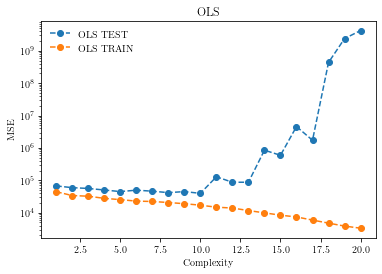

In [3]:
degree_values = np.arange(1,max_degree+1)
plt.semilogy(degree_values, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degree_values, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)

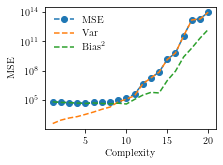

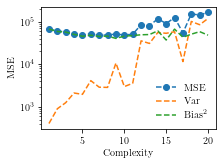

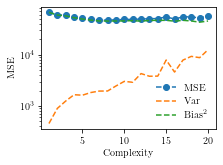

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ols_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)
plt.tight_layout()

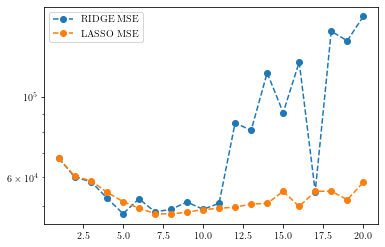

In [5]:
#plt.semilogy(degree_values, ols_boot_mse,"o--",label="OLS MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.legend()

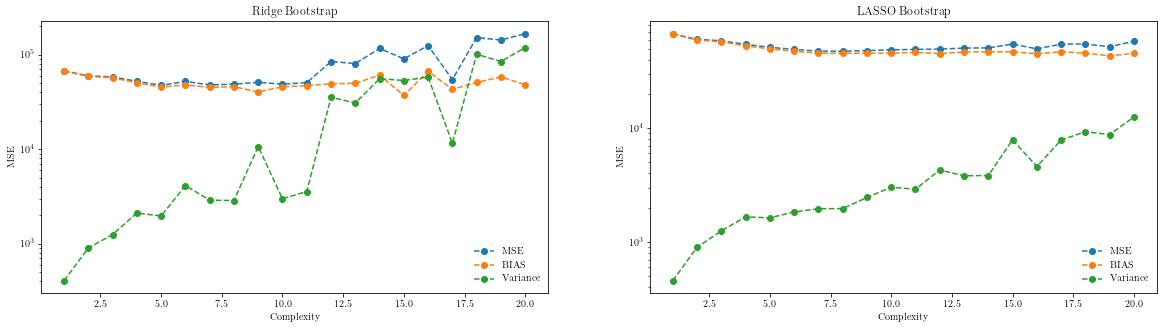

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

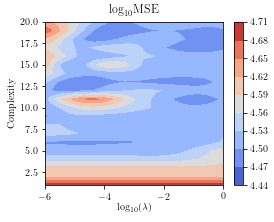

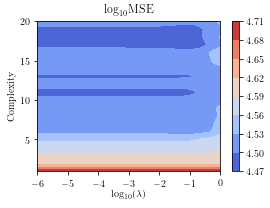

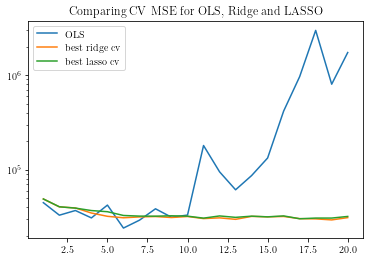

In [7]:
# CONTOUR PLOTS

# RIDGE
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(ridge_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")


# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(lasso_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")
plt.tight_layout()

# CV MSE for OLS, Ridge and LASSO:
plt.figure()
plt.semilogy(degree_values, ols_cv_mse, label ='OLS')
plt.semilogy(degree_values, best_ridge_mse, label="best ridge cv")
plt.semilogy(degree_values, best_lasso_mse, label="best lasso cv")
plt.legend()
plt.title('Comparing CV MSE for OLS, Ridge and LASSO')
plt.show()

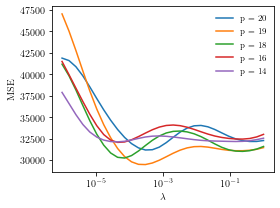

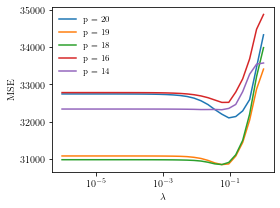

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')


# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')

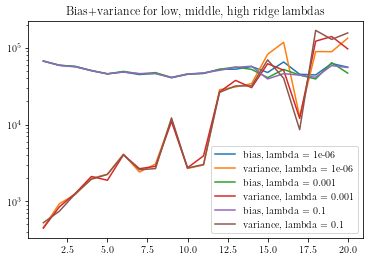

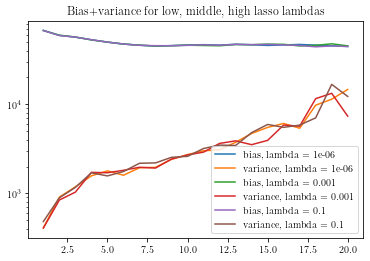

In [9]:
plt.figure()
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high ridge lambdas")
plt.legend()
plt.show()

plt.figure()
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high lasso lambdas")
plt.legend()
plt.show()

In [10]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 1.00000000e+00 1.48735211e-01 3.29034456e-03
 3.29034456e-03 1.74332882e-05 8.53167852e-03 8.53167852e-03
 1.00000000e-06 1.48735211e-01 9.23670857e-02 6.72335754e-06
 1.74332882e-05 4.52035366e-05 6.72335754e-06 4.52035366e-05
 9.23670857e-02 7.27895384e-05 3.03919538e-04 3.03919538e-04]
[1.00000000e-06 9.23670857e-02 3.85662042e-01 1.00000000e-06
 5.29831691e-03 9.23670857e-02 8.53167852e-03 1.00000000e-06
 1.00000000e-06 3.56224789e-02 1.37382380e-02 2.21221629e-02
 8.53167852e-03 5.73615251e-02 3.56224789e-02 5.73615251e-02
 9.23670857e-02 5.73615251e-02 5.73615251e-02 9.23670857e-02]


In [11]:
spacing = 100 # Try 100, and try 40
degree = 18 #Try what seems best from above
ridge_lambda = best_ridge_lambda[degree-1] # Ditto, remember index 0 corresponds to degree 1
lasso_lambda = best_lasso_lambda[degree-1] # Ditto
np.random.seed(SEEDVAL)
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data
terrain_data = imread("../datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:spacing, :1801:spacing]  # Make quadratic and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables

x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection

# Centering
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

x_plot = np.linspace(0, 1, 1801)
y_plot = np.linspace(0, 1, 1801)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]
# Ground truth

z_true = terrain_data[:1801, :1801]

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(-1, 1801)

# Ridge
betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(-1, 1801)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(-1, 1801)


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2281171.1577638453, tolerance: 2576.4506515235457
  positive)


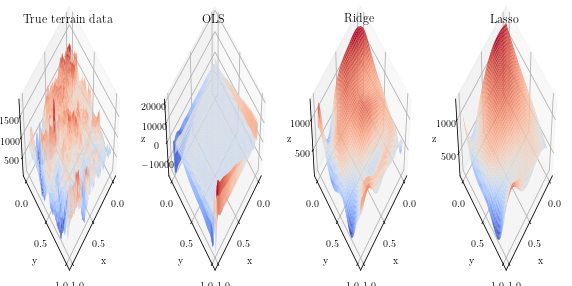

In [12]:
fig = plt.figure(figsize=(10,5))

# Plot the true terrain data
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("True terrain data")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_true, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)

ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)

ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)

plt.show()



In [13]:
print(stat_tools.MSE(z_true, z_predict_ols)) #Prediction MSE for OLS
print(stat_tools.MSE(z_true, z_predict_ridge)) # for Ridge
print(stat_tools.MSE(z_true, z_predict_lasso)) # for Lasso

7515860.642486968
26815.2487914491
32326.00845404966
